# BTO Electro-Optic Modulator

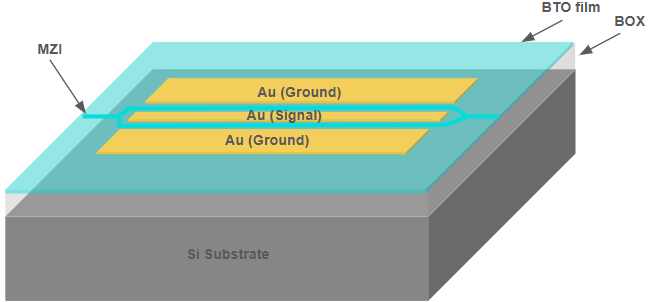

In this notebook, we simulate the product of the half-wave voltage ($V_\pi$) and the interaction length ($L$) for a BTO electro-optic modulator [1]. This is a key performance metric for evaluating the modulation efficiency of electro-optic modulators.

**References**

1. Han, Huangpu, *et al*. "Integrated barium titanate electro-optic modulators operating at CMOS-compatible voltage." *Applied Optics* 2023, 62 (22), 6053–6059. doi: [10.1364/AO.499065](https://doi.org/10.1364/AO.499065)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import tidy3d as td

First, we define the key geometric parameters of the coplanar waveguide (CPW) used in the BTO modulator structure.

In [2]:
signal_width = 3.8  # Width of the CPW signal electrode (µm)
gap_width = 4.4  # Gap width between signal and ground electrodes (µm)
ground_width = 40  # Width of the CPW ground electrode (µm)

These parameters define the technology stack and material dimensions for the thin-film BTO electro-optical modulator

In [3]:
bto_thickness = 0.5  # Thickness of the BTO waveguide core layer (µm)
slab_thickness = 0.25  # Thickness of the BTO slab layer surrounding the core (µm)
box_thickness = 2  # Thickness of the buried oxide (BOX) layer (µm)
tl_thickness = 0.8  # Thickness of the metal transmission line (TL) layer (µm)
tl_separation = 0  # Vertical separation between TL and BTO slab (µm)
sidewall_angle = 0  # Sidewall angle of etched BTO waveguide (degrees)
lambda_0 = 1.55  # Operating wavelength (µm)

## Technology Definition

The `custom_bto_pdk` function creates a [customizable technology](../guides/Custom_Technology.rst) definition for photonic circuit design using a thin-film BTO platform. It includes detailed specifications for material properties, geometric layers, and cross-sectional configurations. Users can precisely control parameters such as BTO core thickness, slab thickness, oxide cladding layers, metallic transmission lines, sidewall angles, and substrate inclusion.


In [4]:
_Medium = td.components.medium.MediumType


@pf.parametric_technology
def custom_bto_pdk(
    *,
    bto_thickness: float = 0.5,
    slab_thickness: float = 0.25,
    sidewall_angle: float = 0,
    box_thickness: float = 2,
    tl_thickness: float = 0.8,
    tl_separation: float = 0,
    include_substrate: bool = True,
    include_top_opening: bool = True,
    sio2: dict[str, _Medium] = {
        "optical": td.material_library["SiO2"]["Palik_Lossless"],
        "electrical": td.Medium(permittivity=3.9, name="SiO2"),
    },
    si: dict[str, _Medium] = {
        "optical": td.material_library["cSi"]["Li1993_293K"],
        "electrical": td.Medium(permittivity=11.7, name="Si"),
    },
    bto: dict[str, _Medium] = {
        "optical": td.AnisotropicMedium(
            xx=td.Medium(permittivity=2.312**2),
            yy=td.Medium(permittivity=2.274**2),
            zz=td.Medium(permittivity=2.312**2),
        ),
        "electrical": td.AnisotropicMedium(
            xx=td.Medium(permittivity=3000),
            yy=td.Medium(permittivity=60),
            zz=td.Medium(permittivity=3000),
        ),
    },
    tl_metal: dict[str, _Medium] = {
        "optical": td.material_library["Au"]["JohnsonChristy1972"],
        "electrical": td.LossyMetalMedium(
            conductivity=41,
            frequency_range=[0.1e9, 300e9],
            fit_param=td.SurfaceImpedanceFitterParam(max_num_poles=16),
        ),
    },
    air: _Medium = td.Medium(permittivity=1.0, name="Air"),
) -> pf.Technology:
    """Create a thin-film Barium Titanate technology.

    Args:
        bto_thickness (float): BTO layer thickness.
        slab_thickness (float): Partially etched slab thickness in BTO.
        sidewall_angle (float): Sidewall angle (in degrees) for BTO etching.
        box_thickness (float): Thickness of the bottom oxide clad.
        tl_thickness (float): TL layer thickness.
        tl_separation (float): Separation between the slab BTO and TL layers.
        include_substrate (bool): Flag indicating whether or not to include
          the silicon substrate.
        include_top_opening (bool): Flag indicating whether or not to
          include the open region above the last extrusion layer.
        sio2 (Medium): Oxide and background medium.
        si (Medium): Silicon medium.
        bto (Medium): BTO medium.
        tl_metal (Medium): TL metal medium.
        air (Medium): Air medium.

    Returns:
        Technology: Parametric technology object for BTO-based PDK.
    """
    # Layers
    layers = {
        "BTO_RIDGE": pf.LayerSpec(
            layer=(2, 0),
            description="BTO etch (ridge)",
            color="#7d57de18",
            pattern="//",
        ),
        "BTO_SLAB": pf.LayerSpec(
            layer=(3, 0), description="BTO etch (full)", color="#00008018", pattern="\\"
        ),
        "SLAB_NEGATIVE": pf.LayerSpec(
            layer=(3, 1),
            description="Slab etch negative",
            color="#6750bf18",
            pattern="\\",
        ),
        "MET": pf.LayerSpec(
            layer=(21, 0),
            description="Metal transmission lines",
            color="#eadb0718",
            pattern="\\",
        ),
    }
    # Extrusion specifications
    bounds = pf.MaskSpec()  # Empty mask for all chip bounds
    full_bto_mask = pf.MaskSpec((2, 0))
    slab_etch_mask = pf.MaskSpec((3, 1), (3, 0), "-")
    met_mask = pf.MaskSpec((21, 0))

    z_tl = slab_thickness + tl_separation
    z_top = bto_thickness

    extrusion_specs = [
        pf.ExtrusionSpec(bounds, bto, (0, slab_thickness), 0),
        pf.ExtrusionSpec(full_bto_mask, bto, (0, bto_thickness), sidewall_angle),
        pf.ExtrusionSpec(slab_etch_mask, air, (0, bto_thickness), -sidewall_angle),
        pf.ExtrusionSpec(met_mask, tl_metal, (z_tl, z_tl + tl_thickness)),
        pf.ExtrusionSpec(bounds, sio2, (-box_thickness, 0)),
    ]

    if include_substrate:
        extrusion_specs.append(
            pf.ExtrusionSpec(bounds, si, (-pf.Z_INF, -box_thickness))
        )

    rwg_port_gap = min(1.5, box_thickness)
    rwg_port_limits = (-rwg_port_gap, bto_thickness + rwg_port_gap)

    technology = pf.Technology(
        "Custom BTO PDK", "1.0", layers, extrusion_specs, {}, air
    )
    technology.ports = {
        "RWG800": pf.PortSpec(
            description="BTO single mode ridge waveguide for C-band, TE mode",
            width=5,
            limits=rwg_port_limits,
            num_modes=1,
            target_neff=2.2,
            path_profiles=((0.8, 0, (2, 0)), (10, 0, (3, 0))),
        ),
        "UniCPW": pf.cpw_spec(
            layer=(21, 0),
            signal_width=3.8,
            gap=4.4,
            ground_width=250,
            added_solver_modes=0,
            target_neff=2.2,
            technology=technology,
        ),
    }
    return technology

Now, we define the technology (`tech`) using our specified parameters and set it as the default for subsequent simulations and designs.


In [5]:
tech = custom_bto_pdk(
    bto_thickness=bto_thickness,
    slab_thickness=slab_thickness,
    sidewall_angle=sidewall_angle,
    box_thickness=box_thickness,
    tl_thickness=tl_thickness,
    tl_separation=tl_separation,
)
pf.config.default_technology = tech

To visualize how each layer is extruded in our defined technology, we create a simple test component (`test_component`) that includes representative rectangles for each technology layer.

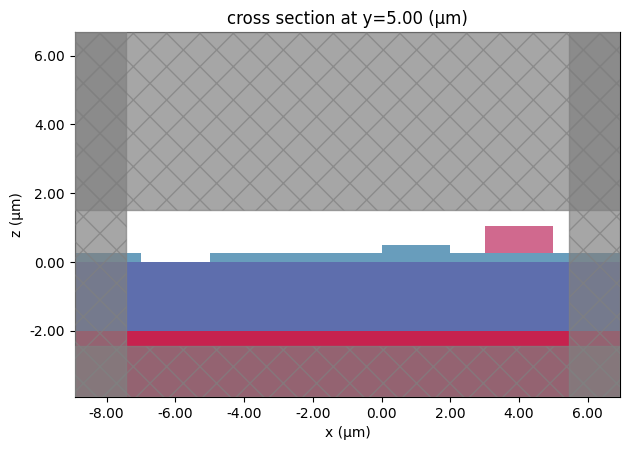

In [6]:
test_component = pf.Component("test")

test_component.add(
    "BTO_RIDGE",
    pf.Rectangle((0, 0), (2, 10)),
    "MET",
    pf.Rectangle((3, 0), (5, 10)),
    "SLAB_NEGATIVE",
    pf.Rectangle((-7, 0), (-4, 10)),
    "BTO_SLAB",
    pf.Rectangle((-5, 0), (-3, 10)),
)

_ = pf.tidy3d_plot(test_component, y=5)

## $V_\pi L$ Calculation
### MZI Cross-Section
We calculate the vertical offset needed to place two optical waveguides symmetrically within the CPW gaps. These waveguides form the arms of a Mach-Zehnder Interferometer (MZI), where the electro-optic modulator induces a phase shift in the arms by applying an RF signal. Using the default technology port specifications, we create a composite MZI cross-section that combines the RF transmission line with the optical waveguides. We then visualize this configuration and overlay the voltage and current integration paths used in the impedance calculation.


12:29:09 -03 WARNING: ℹ️ ⚠️ RF simulations are subject to new license requirements
             in the future. You have instantiated at least one RF-specific      
             component.                                                         

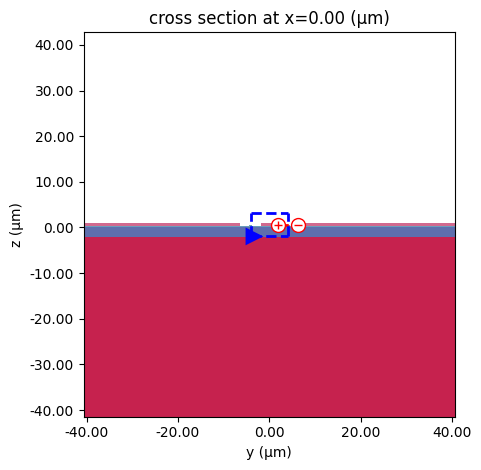

In [7]:
# Calculate the offset for placing waveguides in the middle of the CPW gaps
mzi_offset = signal_width / 2 + gap_width / 2

# Get the optical waveguide port specification ("RWG800")
wg_spec = pf.config.default_technology.ports["RWG800"]

# Get the RF CPW port specification ("UniCPW")
cpw_port = pf.config.default_technology.ports["UniCPW"]

# Create the combined MZI cross-section spec: CPW + two offset waveguides
mzi_spec_rf = cpw_port.combined_with(wg_spec, mzi_offset).combined_with(
    wg_spec, -mzi_offset
)

# Create a Tidy3D impedance calculator instance based on the MZI cross-section
ic = mzi_spec_rf.to_tidy3d_impedance_calculator()

# Plot the MZI cross-section geometry
ax = pf.tidy3d_plot(mzi_spec_rf)

# Plot the voltage integration path on the cross-section
_ = ic.voltage_integral.plot(ax=ax, x=0)

# Plot the current integration path on the cross-section
_ = ic.current_integral.plot(ax=ax, x=0)

### The Electro-Optic Response in the MZI Cross-Section
We simulate the RF mode in the composite CPW + MZI structure at 1 GHz. Using the computed field, we calculate the voltage using the defined integration path, then normalize the electric field component (Ey) by this voltage. This gives us the field distribution per unit volt, which we align with the optical waveguide center. Using the Pockels effect, we then compute the change in refractive index (Δn) within the BTO material due to the applied field. This refractive index change is responsible for inducing a phase shift in the MZI arm, enabling modulation.


12:29:10 -03 WARNING:  ℹ️ ⚠️ RF simulations are subject to new license            
             requirements in the future. You are using RF-specific components in
             this simulation.                                                   
              - Contains a 'LossyMetalMedium'.                                  

Loading cached simulation from .tidy3d/pf_cache/5A4/ms_info-YM3EMMGUCSGOQL2AFGH3WDPS74N7GCYISQVXSMVNTCTZS6ADHLQQ.json.


Progress: 100%


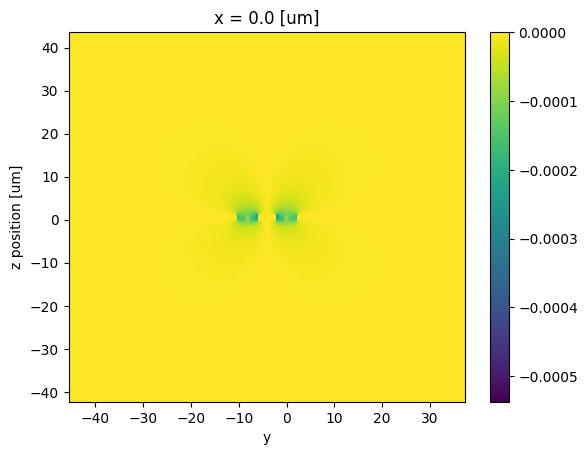

In [8]:
freq_rf = [1e9]  # Frequency at which RF simulation is performed

# Calculate RF modes for the CPW line
mode_solver_rf, z0_rf = pf.port_modes(
    mzi_spec_rf, freq_rf, mesh_refinement=50, impedance=True, group_index=True
)

# Calculate the voltage associated with the simulated RF mode using the defined integral path
v0 = ic.voltage_integral.compute_voltage(mode_solver_rf.data)

# Calculate the normalized Ey field (Ey per unit volt)
ey_norm = (mode_solver_rf.data.Ey / v0).isel(f=0, mode_index=0, drop=True).abs

# Shift y-coordinates to center relative to the optical waveguide position
ey_norm = ey_norm.assign_coords(y=ey_norm.y - mzi_offset)

n_e = 2.274  # Extraordinary refractive index for BTO
n_o = 2.312  # Ordinary refractive index for BTO

# Define the r33 electro-optic coefficient (µm/V)
r33 = 112e-6

# Calculate the change in refractive index (Δn) per unit volt using the Pockels effect
Δn = -0.5 * n_e**3 * r33 * ey_norm

# Plot the calculated Δn distribution in the cross-section (x=0)
_ = Δn.isel(x=0).transpose("z", "y").plot(robust=False)

### Defining a Perturbed Optical Mode Solver

We now create a voltage-dependent optical solver to simulate the electro-optic modulation effect in BTO. The ordinary permittivity (used in the xx and zz directions) is assumed constant, while the extraordinary axis (yy) is perturbed according to the applied voltage and the Pockels-induced refractive index change (Δn). We use this modified anisotropic medium to compute the new optical modes, allowing us to evaluate the phase shift in the MZI arm under different voltage conditions.


In [9]:
# Create a spatially uniform DataArray for the ordinary permittivity (used for xx, zz components)
eps_o_array = td.SpatialDataArray(
    np.full((1, 1, 1), n_o**2), coords={"x": [0], "y": [0], "z": [0]}
)


# Define a function to run the optical mode solver with voltage-perturbed BTO
def perturbed_solver(voltage):
    # Create a custom anisotropic medium definition for BTO including the EO effect
    perturbed_bto = td.CustomAnisotropicMedium(
        xx=td.CustomMedium(permittivity=eps_o_array, subpixel=True),  # ordinary (x)
        yy=td.CustomMedium(
            permittivity=(n_e + voltage * Δn) ** 2, subpixel=True
        ),  # EO perturbed (y)
        zz=td.CustomMedium(permittivity=eps_o_array, subpixel=True),  # ordinary (z)
    )
    # Run the mode solver for the waveguide spec at the optical frequency
    # Use a custom technology where BTO is replaced by the perturbed version
    return pf.port_modes(
        wg_spec, [pf.C_0 / lambda_0], technology=custom_bto_pdk(bto=perturbed_bto)
    )

### Extracting $V_\pi L$

We sweep the applied voltage across a specified range and compute the corresponding optical effective index ($n_\mathrm{eff}$) using the voltage-perturbed solver. By calculating the change in $n_\mathrm{eff}$ per volt, we estimate the modulator’s $V_\pi L$ figure of merit using the standard relation $V_\pi L = \lambda_0 / (2 \, |dn_\mathrm{eff}/dV|)$. The result is reported for both single-drive and push-pull configurations.


Loading cached simulation from .tidy3d/pf_cache/5QA/ms_info-2R7U3ZQZETBGXJRJT3QBJDBATGWAMVXOYGUW2B5YLDCFHLHAD6FQ.json.


Progress: 100%


Loading cached simulation from .tidy3d/pf_cache/YZO/ms_info-DQGSVVJZNWYFKOBUSUS7X6F5HBLIUYXN7RMWJ7NUOF3TBA6CO5XA.json.


Progress: 100%


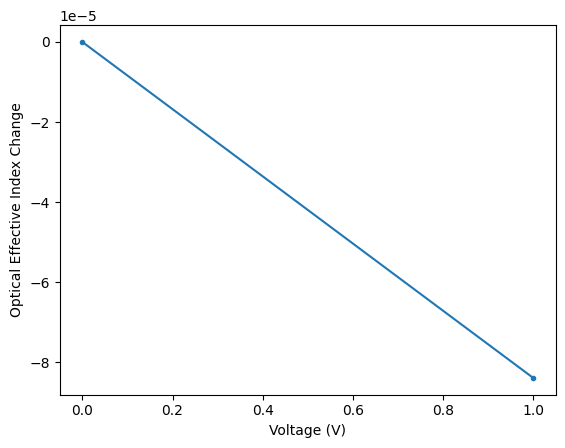

Vπ·L (single-drive) = 0.92 V·cm
Vπ·L (push-pull)    = 0.46 V·cm


In [10]:
td.config.logging_level = "ERROR"

# Define the range of voltages for the sweep
voltages = np.arange(2)

# Calculate optical n_eff for each voltage using the perturbed_solver function
n_eff = [
    perturbed_solver(v).data.n_eff.isel(mode_index=0, f=0).item() for v in voltages
]

# Plot optical effective index change vs applied voltage
delta_n_eff = np.array(n_eff) - n_eff[0]
_ = plt.plot(voltages, delta_n_eff, ".-")
plt.gca().set(xlabel="Voltage (V)", ylabel="Optical Effective Index Change")
plt.show()

# Calculate the change in n_eff per volt (dneff/dV) using the first and last points
dneff_dv = abs(n_eff[-1] - n_eff[0]) / (voltages[-1] - voltages[0])

# Calculate V_pi*L using the formula: Vπ·L = λ₀ / (2 * |dn_eff/dV|)
vpil = 0.5 * lambda_0 / dneff_dv  # Result in V·μm

# Print Vπ·L in V·cm for single-drive configuration
print(f"Vπ·L (single-drive) = {vpil * 1e-4:.2f} V·cm")

# Print Vπ·L in V·cm for push-pull configuration (half of single-drive)
print(f"Vπ·L (push-pull)    = {vpil * 1e-4 / 2:.2f} V·cm")